In [2]:
import os
from tqdm import tqdm
import json
import argparse
import pickle
import torch
import torch.nn as nn
import numpy as np
import pprint
from tensorboardX import SummaryWriter
import re
import gc
import sys
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from numpy.linalg import svd
from mpl_toolkits.mplot3d import Axes3D
import time
import yaml

sys.path = ['..'] + sys.path
from algorithm_trainer.models import gated_conv_net_original, resnet, resnet_2, resnet_12, conv64
from algorithm_trainer.algorithm_trainer import Generic_adaptation_trainer, Classical_algorithm_trainer
from algorithm_trainer.algorithms.algorithm import SVM, ProtoNet, Finetune, ProtoCosineNet
from algorithm_trainer.utils import accuracy
from data_layer.dataset_managers import MetaDataManager, ClassicalDataManager
from analysis.objectives import var_reduction_disc, var_reduction_disc_perp, var_reduction

%matplotlib inline

In [8]:
def load_model(checkpoint):
    
    if dataset_path.split('/')[-1] in ['miniImagenet', 'CUB']:
        model = resnet_12.resnet12(avg_pool=(avg_pool == "True"), drop_rate=0.1, dropblock_size=5,
        no_fc_layer=True, projection=(projection=="True"))
    else:
        model = resnet_12.resnet12(avg_pool=(avg_pool == "True"), drop_rate=0.1, dropblock_size=2,
        no_fc_layer=True, projection=(projection=="True"))
            
    print(f"loading from {checkpoint}")
    model_dict = model.state_dict()
    chkpt_state_dict = torch.load(checkpoint)
    if 'model' in chkpt_state_dict:
        chkpt_state_dict = chkpt_state_dict['model']
    chkpt_state_dict_cpy = chkpt_state_dict.copy()
    # remove "module." from key, possibly present as it was dumped by data-parallel
    for key in chkpt_state_dict_cpy.keys():
        if 'module.' in key:
            new_key = re.sub('module\.', '',  key)
            chkpt_state_dict[new_key] = chkpt_state_dict.pop(key)
    chkpt_state_dict = {k: v for k, v in chkpt_state_dict.items() if k in model_dict}
    model_dict.update(chkpt_state_dict)
    updated_keys = set(model_dict).intersection(set(chkpt_state_dict))
    missed_keys = set(model_dict).difference(set(chkpt_state_dict))
    print(f"Missed {len(missed_keys)} keys")
    model.load_state_dict(model_dict)
    model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
    model.cuda()
    return model

# step 1: Fix 10 different random support sets

In [9]:
img_side_len = 32
n_way_train = 5
n_shot_train = 5
n_query_train = 15
n_query_pool = 15
batch_size_train = 8
support_aug = False
train_aug = False
n_episodes = 125
n_curves = 10
log_interval = 2000
model_type = 'resnet12'
avg_pool = "True"
projection = "False"
dataset_path = '../data/filelists/cifar'
model_path = '../train_dir_2/fixS5_cifar_r12_n20_s5_q15_qp50_euc_run2'

In [10]:
def fetch_loader(seed=None, n_episodes=250, fix_support=0):
    if seed is not None:
        print("Setting seed to", seed)
        np.random.seed(seed)
    image_size = img_side_len
    train_file = os.path.join(dataset_path, 'base.json')
    mt_datamgr = MetaDataManager(
        image_size, batch_size=batch_size_train, n_episodes=n_episodes,
        n_way=n_way_train, n_shot=n_shot_train, n_query=max(n_query_train, n_query_pool), fix_support=fix_support)
    mt_loader = mt_datamgr.get_data_loader(
        dataset_path.split('/')[-1], train_file, support_aug=support_aug, query_aug=train_aug)
    if seed is not None:
        import time
        t = 1000 * time.time() # current time in milliseconds
        np.random.seed(int(t) % 2**32)
        print("Resetting random seed")
    return (mt_loader, mt_datamgr)

In [11]:
def read_random_seed(model_path):
    with open(os.path.join(model_path, 'config.txt')) as f:
        for line in f.readlines():
            line = line.strip('\n')
            if 'random_seed' in line:
                return int(line.split(":")[-1])
    return None

In [12]:
%%capture
random_fixed_support_loaders = [fetch_loader(n_episodes=n_episodes, fix_support=n_shot_train) for _ in range(n_curves)]

In [13]:
vanilla_meta_loader = fetch_loader(n_episodes=500)

support aug: False query aug: False
Support set is fixed: False


In [14]:
specific_support_loader = fetch_loader(seed=read_random_seed(model_path), n_episodes=n_episodes, fix_support=n_shot_train)

Setting seed to 10725
support aug: False query aug: False
Support set is fixed: True
Resetting random seed


# step 2: Load models and evaluate objectives

In [15]:
def evaluate(train_loader, model):
    algorithm = ProtoNet(
        model=model,
        inner_loss_func=torch.nn.CrossEntropyLoss(),
        n_way=n_way_train,
        n_shot=n_shot_train,
        n_query=n_query_train,
        device='cuda')
    trainer = Generic_adaptation_trainer(
        algorithm=algorithm,
        aux_objective=None,
        outer_loss_func=torch.nn.CrossEntropyLoss(),
        outer_optimizer=None, 
        writer=None,
        log_interval=log_interval,
        model_type=model_type)
    with torch.no_grad():
        results = trainer.run(*(train_loader))
    return results

In [18]:
train_loss = defaultdict(list)
r = re.compile(".*pt")
for modelfile in sorted(list(filter(r.match, os.listdir(model_path)))):
    print("**"*50)
    print("loading", modelfile)
    modelfile = os.path.join(model_path, modelfile)
    model = load_model(modelfile)
    for i in range(len(random_fixed_support_loaders)):
        print("--"*20)
        print("Evaluating on random support ", i+1)
        train_loss["random_" + str(i)].append(evaluate(random_fixed_support_loaders[i], model))
    print("--"*20)
    print("Evaluating on specific support ")
    train_loss['specific'].append(evaluate(specific_support_loader, model))
    train_loss['avg'].append(evaluate(vanilla_meta_loader, model))
    print("Saving results ")
    with open("train_analysis_run_"+model_path.split('/')[-1]+".pkl", 'wb') as f:
        torch.save(train_loss, f)

****************************************************************************************************
loading classical_resnet_001.pt
Unit norm projection is  False
Average pooling:  True
loading from ../train_dir_2/fixS5_cifar_r12_n20_s5_q15_qp50_euc_run2/classical_resnet_001.pt
Missed 0 keys
----------------------------------------
Evaluating on random support  1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([9.8128], device='cuda:0')
----------------------------------------
Evaluating on random support  2
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([9.8128], device='cuda:0')
----------------------------------------
Evaluating on random support  3
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([9.8128], device='cuda:0')
----------------------------------------
Evaluating on random support  4
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([9.8128], device='cuda:0')
----------------------

----------------------------------------
Evaluating on random support  7
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.5116], device='cuda:0')
----------------------------------------
Evaluating on random support  8
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.5116], device='cuda:0')
----------------------------------------
Evaluating on random support  9
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.5116], device='cuda:0')
----------------------------------------
Evaluating on random support  10
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.5116], device='cuda:0')
----------------------------------------
Evaluating on specific support 
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.5116], device='cuda:0')
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.5116], device='cuda:0')
Saving results          
***************

Missed 0 keys
----------------------------------------
Evaluating on random support  1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3509], device='cuda:0')
----------------------------------------
Evaluating on random support  2
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3509], device='cuda:0')
----------------------------------------
Evaluating on random support  3
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3509], device='cuda:0')
----------------------------------------
Evaluating on random support  4
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3509], device='cuda:0')
----------------------------------------
Evaluating on random support  5
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3509], device='cuda:0')
----------------------------------------
Evaluating on random support  6
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting

----------------------------------------
Evaluating on random support  9
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2989], device='cuda:0')
----------------------------------------
Evaluating on random support  10
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2989], device='cuda:0')
----------------------------------------
Evaluating on specific support 
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2989], device='cuda:0')
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2989], device='cuda:0')
Saving results          
****************************************************************************************************
loading classical_resnet_012.pt
Unit norm projection is  False
Average pooling:  True
loading from ../train_dir_2/fixS5_cifar_r12_n20_s5_q15_qp50_euc_run2/classical_resnet_012.pt
Missed 0 keys
----------------------------------------
Evaluating on random sup

----------------------------------------
Evaluating on random support  3
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2338], device='cuda:0')
----------------------------------------
Evaluating on random support  4
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2338], device='cuda:0')
----------------------------------------
Evaluating on random support  5
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2338], device='cuda:0')
----------------------------------------
Evaluating on random support  6
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2338], device='cuda:0')
----------------------------------------
Evaluating on random support  7
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2338], device='cuda:0')
----------------------------------------
Evaluating on random support  8
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  ten

----------------------------------------
Evaluating on specific support 
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2063], device='cuda:0')
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2063], device='cuda:0')
Saving results          
****************************************************************************************************
loading classical_resnet_019.pt
Unit norm projection is  False
Average pooling:  True
loading from ../train_dir_2/fixS5_cifar_r12_n20_s5_q15_qp50_euc_run2/classical_resnet_019.pt
Missed 0 keys
----------------------------------------
Evaluating on random support  1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2042], device='cuda:0')
----------------------------------------
Evaluating on random support  2
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2042], device='cuda:0')
----------------------------------------
Evaluating on random supp

----------------------------------------
Evaluating on random support  5
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3477], device='cuda:0')
----------------------------------------
Evaluating on random support  6
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3477], device='cuda:0')
----------------------------------------
Evaluating on random support  7
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3477], device='cuda:0')
----------------------------------------
Evaluating on random support  8
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3477], device='cuda:0')
----------------------------------------
Evaluating on random support  9
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3477], device='cuda:0')
----------------------------------------
Evaluating on random support  10
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  te

Saving results          
****************************************************************************************************
loading classical_resnet_026.pt
Unit norm projection is  False
Average pooling:  True
loading from ../train_dir_2/fixS5_cifar_r12_n20_s5_q15_qp50_euc_run2/classical_resnet_026.pt
Missed 0 keys
----------------------------------------
Evaluating on random support  1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3040], device='cuda:0')
----------------------------------------
Evaluating on random support  2
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3040], device='cuda:0')
----------------------------------------
Evaluating on random support  3
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3040], device='cuda:0')
----------------------------------------
Evaluating on random support  4
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.3040], device='cu

----------------------------------------
Evaluating on random support  7
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2422], device='cuda:0')
----------------------------------------
Evaluating on random support  8
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2422], device='cuda:0')
----------------------------------------
Evaluating on random support  9
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2422], device='cuda:0')
----------------------------------------
Evaluating on random support  10
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2422], device='cuda:0')
----------------------------------------
Evaluating on specific support 
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2422], device='cuda:0')
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.2422], device='cuda:0')
Saving results          
***************

Missed 0 keys
----------------------------------------
Evaluating on random support  1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.1351], device='cuda:0')
----------------------------------------
Evaluating on random support  2
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.1351], device='cuda:0')
----------------------------------------
Evaluating on random support  3
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.1351], device='cuda:0')
----------------------------------------
Evaluating on random support  4
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.1351], device='cuda:0')
----------------------------------------
Evaluating on random support  5
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.1351], device='cuda:0')
----------------------------------------
Evaluating on random support  6
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting

----------------------------------------
Evaluating on random support  9
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.0611], device='cuda:0')
----------------------------------------
Evaluating on random support  10
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.0611], device='cuda:0')
----------------------------------------
Evaluating on specific support 
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.0611], device='cuda:0')
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([11.0611], device='cuda:0')
Saving results          
****************************************************************************************************
loading classical_resnet_037.pt
Unit norm projection is  False
Average pooling:  True
loading from ../train_dir_2/fixS5_cifar_r12_n20_s5_q15_qp50_euc_run2/classical_resnet_037.pt
Missed 0 keys
----------------------------------------
Evaluating on random sup

----------------------------------------
Evaluating on random support  3
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9847], device='cuda:0')
----------------------------------------
Evaluating on random support  4
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9847], device='cuda:0')
----------------------------------------
Evaluating on random support  5
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9847], device='cuda:0')
----------------------------------------
Evaluating on random support  6
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9847], device='cuda:0')
----------------------------------------
Evaluating on random support  7
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9847], device='cuda:0')
----------------------------------------
Evaluating on random support  8
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  ten

----------------------------------------
Evaluating on specific support 
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9783], device='cuda:0')
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9783], device='cuda:0')
Saving results          
****************************************************************************************************
loading classical_resnet_044.pt
Unit norm projection is  False
Average pooling:  True
loading from ../train_dir_2/fixS5_cifar_r12_n20_s5_q15_qp50_euc_run2/classical_resnet_044.pt
Missed 0 keys
----------------------------------------
Evaluating on random support  1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9727], device='cuda:0')
----------------------------------------
Evaluating on random support  2
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9727], device='cuda:0')
----------------------------------------
Evaluating on random supp

----------------------------------------
Evaluating on random support  5
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9538], device='cuda:0')
----------------------------------------
Evaluating on random support  6
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9538], device='cuda:0')
----------------------------------------
Evaluating on random support  7
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9538], device='cuda:0')
----------------------------------------
Evaluating on random support  8
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9538], device='cuda:0')
----------------------------------------
Evaluating on random support  9
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9538], device='cuda:0')
----------------------------------------
Evaluating on random support  10
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  te

Saving results          
****************************************************************************************************
loading classical_resnet_051.pt
Unit norm projection is  False
Average pooling:  True
loading from ../train_dir_2/fixS5_cifar_r12_n20_s5_q15_qp50_euc_run2/classical_resnet_051.pt
Missed 0 keys
----------------------------------------
Evaluating on random support  1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9306], device='cuda:0')
----------------------------------------
Evaluating on random support  2
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9306], device='cuda:0')
----------------------------------------
Evaluating on random support  3
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9306], device='cuda:0')
----------------------------------------
Evaluating on random support  4
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9306], device='cu

----------------------------------------
Evaluating on random support  7
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9266], device='cuda:0')
----------------------------------------
Evaluating on random support  8
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9266], device='cuda:0')
----------------------------------------
Evaluating on random support  9
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9266], device='cuda:0')
----------------------------------------
Evaluating on random support  10
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9266], device='cuda:0')
----------------------------------------
Evaluating on specific support 
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9266], device='cuda:0')
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9266], device='cuda:0')
Saving results          
***************

Missed 0 keys
----------------------------------------
Evaluating on random support  1
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9206], device='cuda:0')
----------------------------------------
Evaluating on random support  2
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9206], device='cuda:0')
----------------------------------------
Evaluating on random support  3
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9206], device='cuda:0')
----------------------------------------
Evaluating on random support  4
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9206], device='cuda:0')
----------------------------------------
Evaluating on random support  5
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting scale to  tensor([10.9206], device='cuda:0')
----------------------------------------
Evaluating on random support  6
n_way: 5, n_shot: 5, n_query: 15, batch_sz: 8
Setting

In [ ]:
train_loss

In [153]:
train_loss[10][58]

{'train_loss_trajectory': defaultdict(float,
             {'loss': array([0.00310932]), 'accu': array([100.])}),
 'test_loss_after': defaultdict(float,
             {'loss': 0.02070162520557642, 'accu': 99.76533355712891}),
 'val_task_acc': '99.77 ± 0.05 %'}

# step 3: plots

In [108]:
val = []
for ep in range(len(train_loss[0])):
    var = 0
    for k in range(0, 10):
        var += (((train_loss[k][ep]['test_loss_after']['accu']) - (train_loss['avg'][ep]['test_loss_after']['accu']))**2)
    val.append(var / 10)

In [20]:
# Create the figure
fig, ax = plt.subplots()

ax.plot(np.arange(len(values)), val, color="r", alpha=0.95)

ax.set_ylabel("Train Accu. Variance")
ax.set_xlabel("Epochs")
ax.set_xticks(np.arange(0, 7))
ax.set_xticklabels([str(x) for x in np.arange(54, 61)])

NameError: name 'val' is not defined

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>

Text(0.5, 1.0, 'CIFAR 5w1s')

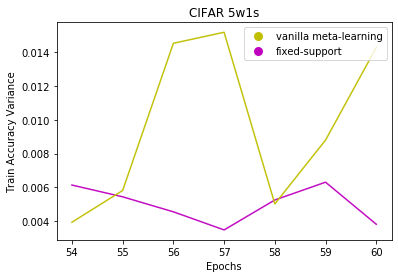

In [114]:
train_loss = torch.load('train_analysis_run_fixS1_cifar_r12_n5_s1_q15_qp50_bs8_euc_metaoptdataaug_sansgap_supportaug_drop20_run1.pkl')
val2 = []
for ep in range(53, 60):
    var = 0
    for k in range(0, 10):
        var += (((train_loss[k][ep]['test_loss_after']['accu']) - (train_loss['avg'][ep]['test_loss_after']['accu']))**2)
    val2.append(var / 10)
    
fig, ax = plt.subplots()
ax.plot(np.arange(len(values)), val2, color="m", alpha=0.95)
ax.plot(np.arange(len(values)), val, color="y", alpha=0.95)

ax.set_ylabel("Train Accuracy Variance")
ax.set_xlabel("Epochs")
ax.set_xticks(np.arange(0, 7))
ax.set_xticklabels([str(x) for x in np.arange(54, 61)])

legend_elements = [Line2D([0], [0], marker='o', color='w', label='vanilla meta-learning',
                          markerfacecolor='y', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='fixed-support',
                          markerfacecolor='m', markersize=10)]

ax.legend(handles=legend_elements, loc='upper right')
plt.title('CIFAR 5w1s')

In [ ]:
train_loss = torch.load('train_analysis_run_fixS1_cifar_r12_n5_s1_q15_qp50_bs8_euc_metaoptdataaug_sansgap_supportaug_drop20_run1.pkl')
v

In [4]:
!ls -lrth

total 997M
drwxr-xr-x 2 amrith amrith 4.0K Jun 25 07:27 scripts
-rw-r--r-- 1 amrith amrith 9.9K Jul  4 15:21 main_analysis.py
drwxr-xr-x 2 amrith amrith 4.0K Jul  6 10:20 models
-rw-r--r-- 1 amrith amrith   60 Aug 10 05:03 CUB-r12-metal-newgradanalysis-optsaved-saugtrue.out
-rw-r--r-- 1 amrith amrith  87M Aug 10 14:31 features.pkl
-rw-r--r-- 1 amrith amrith  48M Aug 13 13:55 soln_pair.pkl
-rw-r--r-- 1 amrith amrith 2.8K Aug 15 18:18 metrics_meta.pkl
-rw-r--r-- 1 amrith amrith 478M Aug 15 22:57 solns_fixS.pkl
-rw-r--r-- 1 amrith amrith 144M Aug 16 07:44 solns_fixS_2.pkl
-rw-r--r-- 1 amrith amrith  48M Aug 16 13:39 meta_soln_3.pkl
-rw-r--r-- 1 amrith amrith  48M Aug 16 13:39 meta_soln_2.pkl
-rw-r--r-- 1 amrith amrith  48M Aug 16 13:41 meta_soln_1.pkl
-rw-r--r-- 1 amrith amrith  96M Aug 16 13:41 meta_soln_1.pkl_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter.h5
-rw-r--r-- 1 amrith amrith  50K Aug 16 14:36 meta_soln_1.pkl_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_y

In [19]:
train_loss['avg']

[]

In [28]:
train_loss.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 'avg'])

In [14]:
a = []
for x in range(1, 11):
    a.append([train_loss[x][y]['test_loss_after']['loss'] for y in range(len(train_loss[x]))])

In [18]:
a = np.array(a).mean(0)

In [19]:
a.shape

(60,)

In [22]:
train_loss.keys()

dict_keys(['random_0', 'random_1', 'random_2', 'random_3', 'random_4', 'random_5', 'random_6', 'random_7', 'random_8', 'random_9', 'specific', 'avg', 1, 2, 3, 4, 5, 6, 7, 8, 9, 0])

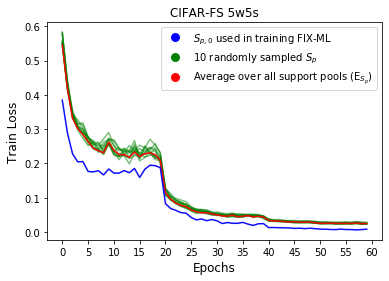

In [9]:
train_loss = torch.load('train_analysis_run_fixS5_cifar_r12_n20_s5_q15_qp50_euc_run2.pkl')
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Create the figure
fig, ax = plt.subplots()

for k in range(0, 10):
    values = [train_loss["random_"+str(k)][x]['test_loss_after']['loss'] for x in range(len(train_loss["random_"+str(k)]))]
    ax.plot(np.arange(len(values)), values, color="g", alpha=0.5)
values = [train_loss['avg'][x]['test_loss_after']['loss'] for x in range(len(train_loss['avg']))]
ax.plot(np.arange(len(values)), values, color="r", alpha=0.95)
values = [train_loss['specific'][x]['test_loss_after']['loss'] for x in range(len(train_loss['avg']))]
ax.plot(np.arange(len(values)), values, color="b", alpha=0.95)

ax.set_ylabel("Train Loss", size=12)
ax.set_xlabel("Epochs", size=12)
# ax.set_xticks(np.arange(0, 61))
# ax.set_xticklabels([str(x) for x in np.arange(0, 61)])
ax.set_xticks(np.arange(0, len(train_loss["avg"])+5, 5))

legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='$S_{p,0}$ used in training FIX-ML',
                          markerfacecolor='b', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='10 randomly sampled $S_{p}$',
                          markerfacecolor='g', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Average over all support pools $(\mathrm{E}_{S_p})$',
                          markerfacecolor='r', markersize=10)]

ax.legend(handles=legend_elements, loc='upper right')
plt.title('CIFAR-FS 5w5s')
# plt.show()
plt.savefig('CIFAR-FS-5w5s-trajectory.pdf')

In [37]:
!ls

analysis
asym_val1.pkl
asym_val_2.pkl
asym_val_3.pkl
asym_val_minmax.pkl
asym_val.pkl
backbone_analysis.ipynb
CUB-r12-metal-newgradanalysis-optsaved-saugtrue.out
curvature-analysis.ipynb
features.pkl
fixS1_cifar_r12_n5_s1_q15_qp50_bs8_euc_metaoptdataaug_sansgap_supportaug_drop20_run1_classical_resnet_021_200_support.pkl
fixS1_cifar_r12_n5_s1_q15_qp50_bs8_euc_metaoptdataaug_sansgap_supportaug_drop20_run1_classical_resnet_060_200_support.pkl
main_analysis.py
metal_cifar_r12_n5_s1_q15_qp15_bs8_euc_metaoptdataaug_sansgap_supportaug_drop20_run1_classical_resnet_028_200_support.pkl
metal_cifar_r12_n5_s1_q15_qp15_bs8_euc_metaoptdataaug_sansgap_supportaug_drop20_run1_classical_resnet_060_200_support.pkl
meta_soln_1.pkl
meta_soln_1.pkl_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter.h5
meta_soln_1.pkl_weights_xignore=biasbn_xnorm=filter_yignore=biasbn_ynorm=filter.h5_[-1.0,1.0,51]x[-1.0,1.0,51].h5
meta_soln_2.pkl
meta_soln_3.pkl
metrics_meta.pkl
metrics_rhv_cub_fixS.pkl
metrics_

In [44]:
train_loss[10]

[{'train_loss_trajectory': defaultdict(float,
              {'loss': array([0.25629616]), 'accu': array([100.])}),
  'test_loss_after': defaultdict(float,
              {'loss': 1.0081996071338652, 'accu': 60.64333491325378}),
  'val_task_acc': '60.64 ± 0.54 %'},
 {'train_loss_trajectory': defaultdict(float,
              {'loss': array([0.13465715]), 'accu': array([100.])}),
  'test_loss_after': defaultdict(float,
              {'loss': 0.7857643225193024, 'accu': 69.87200162410736}),
  'val_task_acc': '69.87 ± 0.57 %'},
 {'train_loss_trajectory': defaultdict(float,
              {'loss': array([0.11450848]), 'accu': array([100.])}),
  'test_loss_after': defaultdict(float,
              {'loss': 0.7046376715898514, 'accu': 73.8313353061676}),
  'val_task_acc': '73.83 ± 0.51 %'},
 {'train_loss_trajectory': defaultdict(float,
              {'loss': array([0.07119277]), 'accu': array([100.])}),
  'test_loss_after': defaultdict(float,
              {'loss': 0.6278678724765777, 'accu': 76.

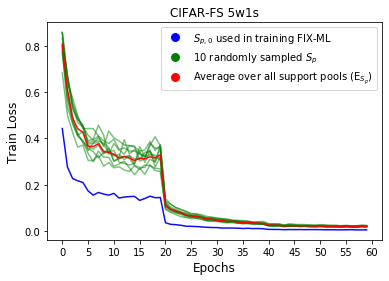

In [7]:
train_loss = torch.load('train_analysis_run_fixS1_cifar_r12_n5_s1_q15_qp50_bs8_euc_metaoptdataaug_sansgap_supportaug_drop20_run1.pkl')
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Create the figure
fig, ax = plt.subplots()

for k in range(0, len(train_loss)):
    values = [train_loss[k][x]['test_loss_after']['loss'] for x in range(len(train_loss[k]))]
    ax.plot(np.arange(len(values)), values, color="b" if k==0 else "g", alpha=0.95 if k==0 else 0.5)
values = [train_loss['avg'][x]['test_loss_after']['loss'] for x in range(len(train_loss['avg']))]
ax.plot(np.arange(len(values)), values, color="r", alpha=0.95)

ax.set_ylabel("Train Loss", size=12)
ax.set_xlabel("Epochs", size=12)
# ax.set_xticks(np.arange(0, 7))
# ax.set_xticklabels([str(x) for x in np.arange(0, 61)])
ax.set_xticks(np.arange(0, len(train_loss[0])+5, 5))

legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='$S_{p,0}$ used in training FIX-ML',
                          markerfacecolor='b', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='10 randomly sampled $S_{p}$',
                          markerfacecolor='g', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='Average over all support pools $(\mathrm{E}_{S_p})$',
                          markerfacecolor='r', markersize=10)]

ax.legend(handles=legend_elements, loc='upper right')
plt.title('CIFAR-FS 5w1s')
# plt.show()
plt.savefig('CIFAR-FS-5w1s-trajectory.svg')

In [77]:
train_loss = torch.load('train_analysis_run_fixS1_cifar_r12_n5_s1_q15_qp50_bs8_euc_metaoptdataaug_sansgap_supportaug_drop20_run1.pkl')

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Create the figure
fig, ax = plt.subplots()

for k in range(1, len(train_loss)):
    values = [train_loss[k][x]['test_loss_after']['loss'] for x in range(len(train_loss[k]))][20:30]
    ax.plot(np.arange(len(values)), values, color="b" if k==0 else "g", alpha=0.95 if k==0 else 0.5)
values = [train_loss['avg'][x]['test_loss_after']['loss'] for x in range(len(train_loss['avg']))][20:30]
ax.plot(np.arange(len(values)), values, color="r", alpha=0.95)

ax.set_ylabel("Train Loss")
ax.set_xlabel("Epochs")
# ax.set_xticks(np.arange(0, 7))
# ax.set_xticklabels([str(x) for x in np.arange(0, 61)])
ax.set_xticks(np.arange(0, len(train_loss[0])+5, 5))

legend_elements = [
#             Line2D([0], [0], marker='o', color='w', label='original support',
#                           markerfacecolor='b', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='10 random supports',
                          markerfacecolor='g', markersize=10),
                  Line2D([0], [0], marker='o', color='w', label='vanilla meta-learning',
                          markerfacecolor='r', markersize=10)]

ax.legend(handles=legend_elements, loc='upper right')
plt.title('CIFAR 5w1s meta-learning')
plt.show()

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>

In [76]:
for k in range(len(train_loss)):
    values = [train_loss[k][x]['test_loss_after']['accu'] for x in range(len(train_loss[k]))]
    plt.plot(np.arange(len(values)), values, color="b" if k==0 else "r")
plt.legend()
plt.show()

No handles with labels found to put in legend.


RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 432x288 with 1 Axes>

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


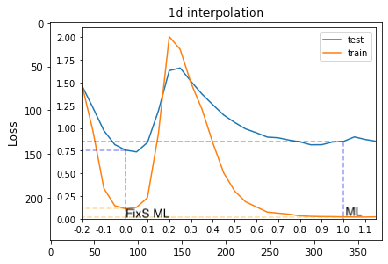

In [22]:
import matplotlib
from matplotlib import rc
rc('font', **{'family':'serif','serif':['Palatino']})
rc('text', usetex=False)
img = matplotlib.pyplot.imread('1d-interpolation-fixml-ml-miniimg.png', format='png')
plt.title('1d interpolation')
plt.ylabel('Loss', size=12)
# plt.xlabel('alpha', size=12)
plt.imshow(img)